<a href="https://colab.research.google.com/github/zuzking/Reddit-comment-wallstreetbet/blob/main/wallstreetbets2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

## Part 0: Load Packages, Load Data


In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("n't")
stopwords.append("br")

# customize stopwords 
custom_st = ['a','the', 'and', 'there', 'that', 'this', 'am', 'on',
                       'if', 'it', 'to', 'at' 'a', 'of', 'in', 'out', 'were',
                       'was', 'do', 'did', "don't","didn't", 'be', 'are', 'is',
                       'being', "it's", 'have', 'had', 's', 'j', 't', 're',
                       'at', 'with', 'just', 'now', "can't", 'can', 'up',
                       'as', 'from', 'thing', 'by', 'so', 'here', 'will', 'for',
                   '.', ',', '‚Äô', '?', '[', ']', '‚Ä¶', 'going', 'want', 'know', 'look', 
                   'would', 'said', 'got', 'think', 'say', 'tell', 'go', 'get', 
                    'crosstalk', 'well', 'like', 'much', 'make']
total_stop = stopwords + custom_st


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/drive/train.csv')
data = pd.read_csv('/content/drive/MyDrive/drive/reddit_wsb.csv')
data1 = pd.read_csv('/content/drive/MyDrive/drive/data_wsb.csv')
data_c = pd.read_csv('/content/drive/MyDrive/drive/data_c.csv')
data_wsb2 = pd.read_csv('/content/drive/MyDrive/drive/data_wsb2.csv')

##Part1: Data Manipulation and Data Exploration

In [ ]:
# concat comment body and title
data['body']= data['body'].fillna('')

data['title'] = data['title'].replace(np.nan, '')

data['total'] = data[['title', 'body']].agg('. '.join, axis=1) # concat title and body 


# deal with timestamp data
k = []
for i in data['timestamp']:
    j = i[:10]
    k.append(j)
    
kk=[]
for ii in data['timestamp']:
    jj = ii[-8:]
    kk.append(jj)

data['day'] = k
data['time'] = kk

#df['Courses'].astype(str) +"-"+ df["Duration"]

#data['total'] = data['title'].astype(str)+","+data['body'] 

#data = data[['title', 'body','total','timestamp','sentiment','comms_num','id']]

In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
t1 = pd.to_datetime('2021-01-28', format = '%Y/%m/%d')
data['day'] =  pd.to_datetime(data['day'], format = '%Y/%m/%d')

In [ ]:
data.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body           timestamp  \
0                                                    2021-01-28 21:37:41   
1                                                    2021-01-28 21:32:10   
2  The CEO of NASDAQ pushed to halt trading ‚Äúto g... 2021-01-28 21:30:35   
3                                                    2021-01-28 21:28:57   
4                                                    2021-01-28 21:26:56   

                                               total        day      time  
0  It's not about the money, it's about sending a... 2021-01-28  21:37:41  
1  Math Professor Scott Steiner says the numbers ... 2021-01-28  21:32:10  
2  Exit the system. The CEO of NASDAQ pushed to h... 2021-01-28  21:30:35  
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR... 2021-01-28  21:28:57  
4  Not to distract from GME, just thought our AMC... 2021-01-28  21:26:56

In [ ]:
# remove outlier which coule be a typo 
data['day'].describe()
data = data.drop(labels = 32591, axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


Text(0.5, 1.0, 'Number of comments before data processing')

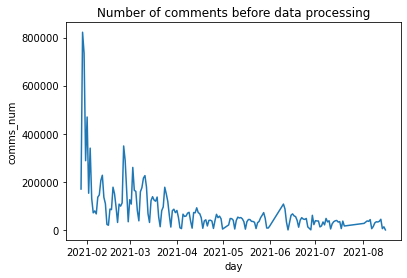

In [ ]:
comments_num = data.groupby(['day'])['comms_num'].sum()
sns.lineplot(data = comments_num)
plt.title('Number of comments before data processing')

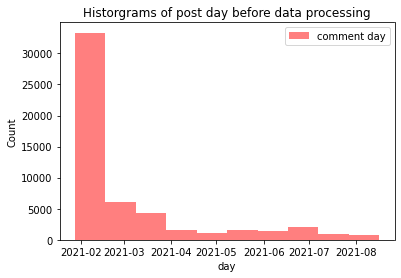

In [ ]:
plt.hist(data['day'].values, alpha = 0.5, color='r', label = 'comment day')
plt.legend(loc ='upper right')
plt.title('Historgrams of post day before data processing')
plt.xlabel('day')
plt.ylabel('Count')
plt.show()

Diamond hands, Paper hands? YOLO?

In [ ]:
# Identity key words

diamond_hand = ['Diamond Hands', 'Diamond hands', 'diamond hand','diamondhands','Diamondhands'] # ,'diamond','Diamond' ? should i put them in?
paper_hand = ['Paper Hands', 'Paper hands', 'paper hands','paperhands','Paperhands']
yolo = ['YOLO', 'yolo', 'Yolo']

def id_words(comment, keys):
    flag = 0 
    for key in keys:
        if comment.find(key) != -1:
            flag = 1
    return flag

data['diamond_label'] = data['total'].apply(lambda x: id_words(x, diamond_hand))
data['yolo_label'] = data['total'].apply(lambda x: id_words(x, yolo))
data['paper_label'] =  data['total'].apply(lambda x: id_words(x, paper_hand))

In [ ]:
#data_wsb2['diamond_label'] = data_wsb2['total'].apply(lambda x: id_words(x, diamond_hand))
#data_wsb2['yolo_label'] = data_wsb2['total'].apply(lambda x: id_words(x, yolo))
#data_wsb2['paper_label'] =  data_wsb2['total'].apply(lambda x: id_words(x, paper_hand))

In [ ]:
data['diamond_label'].sum()

1514

In [ ]:
data['yolo_label'].sum()

3329

In [ ]:
data_wsb2['diamond_label'].sum()

1120

In [ ]:
diamond = data[data['diamond_label'] ==1].groupby(['day'])['title'].nunique()
yolo = data[data['yolo_label'] ==1].groupby(['day'])['title'].nunique()
paper = data[data['paper_label'] ==1].groupby(['day'])['title'].nunique()

In [ ]:
len(paper)

76

Text(0.5, 1.0, 'Number of YOLO label')

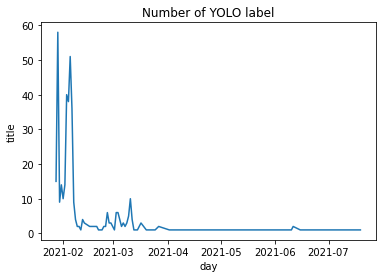

In [ ]:
sns.lineplot(data = paper)
plt.title('Number of YOLO label')

Text(0.5, 1.0, 'Number of Paper hands label')

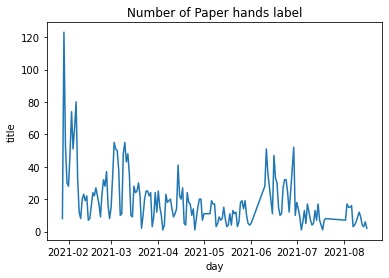

In [ ]:
sns.lineplot(data = yolo)
plt.title('Number of Paper hands label')

Text(0.5, 1.0, 'Number of Diamond hands label')

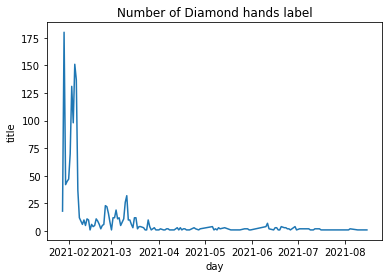

In [ ]:
#comments_num = .groupby(['day'])['comms_num'].sum()
sns.lineplot(data = diamond)
plt.title('Number of Diamond hands label')

## Part 2 Apply Bert Pretrained Model 

Install dependencies: to avoid the conflication between tensorflow and pytorch, the follosing bert related code is better to execut in a differet environment.

In [ ]:
# !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

# !pip install transformers requests pandas numpy

'''
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# test result 
tokens = tokenizer.encode("THIS IS THE MOMENT. Life isn't fair", return_tensors='pt')
result = model(tokens)
result.logits

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

data['sentiment_total'] = data['title'].apply(lambda x: sentiment_score(x[:512]))

# werite to csv 
data.to_csv('data_wsb.csv')
'''

## Part 3: Training LSTM for Toxicity detection 
To train LSTM by using 90% train dataset and evaluate it's profermance on the 10% train dataset

Then deployed the LSTM model on wallstreetbets comments to detect toxic comments



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/drive/train.csv')
#data = pd.read_csv('/content/drive/MyDrive/drive/reddit_wsb.csv')
#data = pd.read_csv('/content/drive/MyDrive/drive/data_wsb.csv')
#data_c = pd.read_csv('/content/drive/MyDrive/drive/data_c.csv')
#data_wsb2 = pd.read_csv('/content/drive/MyDrive/drive/data_wsb2.csv')

In [ ]:
df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
vectorizer.adapt(X_train.values)

In [ ]:
vectorized_text = vectorizer(X_train.values)
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y_train))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.3))
#test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Create Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [ ]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
6283/6283 [==============================] - 743s 118ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 2/20
6283/6283 [==============================] - 745s 119ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 3/20
6283/6283 [==============================] - 746s 119ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 4/20
6283/6283 [==============================] - 744s 118ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 5/20
6283/6283 [==============================] - 740s 118ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/20
6283/6283 [==============================] - 739s 118ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 7/20
6283/6283 [==============================] - 740s 118ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 8/20
6283/6283 [==============================] - 739s 118ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 9/20
6283/6283 [==============================] - 741s 118ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 10/20
6283/6283 [=======================

In [ ]:
model.save('toxicity3.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity3.h5')

In [ ]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

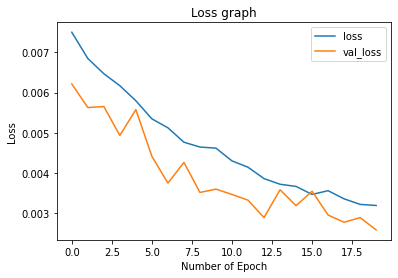

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title("Loss graph")
plt.show()

Test model

In [ ]:
input_text = vectorizer("I come back to you now... At the turn of the tide.. ")

In [ ]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0])>

In [ ]:
model.predict(np.array([input_text]))

1/1 [==============================] - 5s 5s/step


array([[6.8497241e-01, 2.7910284e-05, 2.5040621e-02, 8.8541628e-06,
        2.6134802e-02, 1.0274887e-03]], dtype=float32)

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
def score(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    return results

In [ ]:
bb = []
for j in X_test:
    b = score(j)
    bb.append(b)

In [ ]:
bbb = list(np.concatenate(bb).flat)

b1 = np.array(bbb).reshape(15958,6)

b1 = pd.DataFrame(b1)

In [ ]:
b1.to_csv('b2.csv')

In [ ]:
b1.head()

0             1         2             3         4             5
0  9.118920e-02  9.778071e-07  0.012503  4.921037e-03  0.000954  2.655410e-04
1  9.335384e-12  0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000e+00
2  8.438808e-19  0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000e+00
3  6.779801e-12  0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000e+00
4  9.956542e-01  7.480094e-04  0.880914  2.595362e-11  0.088501  5.927832e-09

## Measure LSTM model Performance 

In [ ]:
data_y = pd.DataFrame(y_test)
data_y.columns = df.columns[2:]
# Choose 0.5 as default threshold  

def judge(x):
    if x >=0.5:
        return 1
    else:
        return 0

In [ ]:
b1.columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']

Calculate Accuracy, F1, precision, Recall... for different category 


In [ ]:
# we can measure these metrics by using the following code all the scores are over 90%

In [ ]:
b1['toxic']= b1['toxic'].apply(judge) 

y_te_toxic = data_y['toxic']
y_pred_toxic=b1['toxic']

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cm = confusion_matrix(y_te_toxic, y_pred_toxic)  

cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1']) 
recall_r = float(cm[0,0]) / (cm[0,1] + cm[0,0])
precision_p = float(cm[0,0]) / (cm[0, 0] + cm[1,0])
f1_f = 2*recall_r*precision_p/(recall_r+precision_p)
acc_s = accuracy_score(y_te_toxic, y_pred_toxic)


In [ ]:
acc_s

0.933450307056022

## Part 4: Deploy LSTM Model on Wallstreetbets to discover 'toxic' comments



In [ ]:
aa=[]
for i in data['total']:
  a = score(i)
  aa.append(a)

aaa = list(np.concatenate(aa).flat)

a1 = np.array(aaa).reshape(53187,6)

a1 = pd.DataFrame(a1)

In [ ]:
aaa = list(np.concatenate(aa).flat)

a1 = np.array(aaa).reshape(53187,6)

a1 = pd.DataFrame(a1)

In [ ]:
a1.to_csv('a11.csv')

In [ ]:
def dig(x):
  if x >= 0.5:
    return 1
  else:
    return 0

In [ ]:
#a1 = a1.iloc[:,1:]
a1.columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']

a1['toxic'] = a1['toxic'].apply(dig)
a1['severe_toxic'] = a1['severe_toxic'].apply(dig)
a1['obscene'] = a1['obscene'].apply(dig)
a1['threat'] = a1['threat'].apply(dig)
a1['insult'] = a1['insult'].apply(dig)
a1['identity_hate'] = a1['identity_hate'].apply(dig)

In [ ]:
a1.head()

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0              0
1      0             0        0       0       0              0
2      0             0        0       0       1              0
3      0             0        0       0       0              0
4      0             0        0       0       0              0

## Save result 

At this point, we could get the toxic comments user id

In [ ]:
data_c = pd.concat([data, a1], axis = 1)

#data_c = data_c.drop(labels = 32591, axis = 0)

In [ ]:
data_wsb2 = data_wsb2.iloc[:,2:]

In [ ]:
data_wsb2.head(50)

title  \
0   It's not about the money, it's about sending a...   
1   Math Professor Scott Steiner says the numbers ...   
2                                     Exit the system   
3   NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...   
4   Not to distract from GME, just thought our AMC...   
5                                 WE BREAKING THROUGH   
6         SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE   
7                                  THIS IS THE MOMENT   
8   Currently Holding AMC and NOK - Is it retarded...   
9   I have nothing to say but BRUH I am speechless...   
10  We need to keep this movement going, we all ca...   
11                 GME Premarket üçÅ Musk approved üéÆüõëüíé‚úã   
12  Once you're done with GME - $AG and $SLV, the ...   
13  $GME price has nothing to do with fundamentals...   
14                             I Love You Retards!!!!   
15                       420 wasn‚Äôt a meme. GME üöÄ üöÄ üöÄ   
16                        To The Mass Relays & Beyond   
17  I come back to you now... At the turn of the t...   
18   9 words brought to you by the fuckers at the SEC   
19       Daily Discussion Thread for January 28, 2021   
20  GME 420.69 Pre-Market. Repeat after me: $1000 ...   
21  We need to stick together and üíéüñê the ever lovi...   
22  Patcher and other media outlets calling this a...   
23    I'm so proud of how far this subreddit has come   
24  Technical Analysis of GameStop ($GME) - TO THE...   
25     Really? I can‚Äôt even buy GME or AMC for now? üò§   
26        I‚Äôve got a friend who is all in on GME üöÄüíéüôåüèº   
27      Y'all broke it. How do we fix it? Any advice?   
28  JUST PUT IN ANOTHER 30K IN NOK CALLS LET'S GO!...   
29  It ain‚Äôt much, but I‚Äôm in! From Germany to the...   
30            Are we ready to attack the Citadel !!!!   
31  Another devastating hit, Europoors using Tradi...   
32                $GME back up to ~350USD after hours   
33  I don‚Äôt have as much as the rest of you guys b...   
34  They're trying to say this was all done by 'Na...   
35     My brokerage wants to force close my GME calls   
36  Guys i just want to say , i never been more pr...   
37                                     Iacta alea est   
38                                Rocketship to Mars!   
39             There is an alternative to this system   
40  Feeling like exercising, dunno may delete this...   
41                          wsb_churchill_speech.mp69   
42  GME Gang - 34 Consecutive Days on NYSE Thresho...   
43  Woke up to an extra $25k. Think the app took a...   
44  Why is GME blank I have 2 screen shots 2am cal...   
45                       THE DARK STOCK RISES.... üöÄü¶áüöÄ   
46  The real price for GME is infinity, but at tha...   
47     OG's......Prepare to show the world who we are   
48  Here's a little background about one of the le...   
49                                               $GME   

                                                 body  \
0                                                 NaN   
1                                                 NaN   
2   The CEO of NASDAQ pushed to halt trading ‚Äúto g...   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6   Hedgefund whales are spreading disinfo saying ...   
7   Life isn't fair. My mother always told me that...   
8                                                 NaN   
9                                                 NaN   
10   I believe right now is one of those rare oppo...   
11                                                NaN   
12  You guys are champs. GME... who would have tho...   
13  Firstly, all of you diamond hands and smooth-b...   
14                                                NaN   
15                                                NaN   
16                                                NaN   
17                                             

## Part 5  VaderSentiment 

In [ ]:
#pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 125 kB 14.9 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
data_c['vader_score'] = data_c['total'].apply(lambda s: vader_sentiment.polarity_scores(s)['compound'])

Save results

In [ ]:
data_c.to_csv('data_c.csv')

In [ ]:
data_c.head(20)

Unnamed: 0                                              title  \
0            0  It's not about the money, it's about sending a...   
1            1  Math Professor Scott Steiner says the numbers ...   
2            2                                    Exit the system   
3            3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...   
4            4  Not to distract from GME, just thought our AMC...   
5            5                                WE BREAKING THROUGH   
6            6        SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE   
7            7                                 THIS IS THE MOMENT   
8            8  Currently Holding AMC and NOK - Is it retarded...   
9            9  I have nothing to say but BRUH I am speechless...   
10          10  We need to keep this movement going, we all ca...   
11          11                 GME Premarket üçÅ Musk approved üéÆüõëüíé‚úã   
12          12  Once you're done with GME - $AG and $SLV, the ...   
13          13  $GME price has nothing to do with fundamentals...   
14          14                             I Love You Retards!!!!   
15          15                       420 wasn‚Äôt a meme. GME üöÄ üöÄ üöÄ   
16          16                        To The Mass Relays & Beyond   
17          17  I come back to you now... At the turn of the t...   
18          18   9 words brought to you by the fuckers at the SEC   
19          19       Daily Discussion Thread for January 28, 2021   

                                                 body  \
0                                                 NaN   
1                                                 NaN   
2   The CEO of NASDAQ pushed to halt trading ‚Äúto g...   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6   Hedgefund whales are spreading disinfo saying ...   
7   Life isn't fair. My mother always told me that...   
8                                                 NaN   
9                                                 NaN   
10   I believe right now is one of those rare oppo...   
11                                                NaN   
12  You guys are champs. GME... who would have tho...   
13  Firstly, all of you diamond hands and smooth-b...   
14                                                NaN   
15                                                NaN   
16                                                NaN   
17                                                NaN   
18                                                NaN   
19  Your daily trading discussion thread. Please k...   

                                                total            timestamp  \
0   It's not about the money, it's about sending a...  2021-01-28 21:37:41   
1   Math Professor Scott Steiner says the numbers ...  2021-01-28 21:32:10   
2   Exit the system. The CEO of NASDAQ pushed to h...  2021-01-28 21:30:35   
3   NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...  2021-01-28 21:28:57   
4   Not to distract from GME, just thought our AMC...  2021-01-28 21:26:56   
5                               WE BREAKING THROUGH.   2021-01-28 21:26:30   
6   SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE. H...  2021-01-28 21:26:27   
7   THIS IS THE MOMENT. Life isn't fair. My mother...  2021-01-28 21:19:31   
8   Currently Holding AMC and NOK - Is it retarded...  2021-01-28 21:19:16   
9   I have nothing to say but BRUH I am speechless...  2021-01-28 21:18:37   
10  We need to keep this movement going, we all ca...  2021-01-28 21:18:25   
11               GME Premarket üçÅ Musk approved üéÆüõëüíé‚úã.   2021-01-28 21:17:28   
12  Once you're done with GME - $AG and $SLV, the ...  2021-01-28 21:17:10   
13  $GME price has nothing to do with fundamentals...  2021-01-28 21:15:58   
14                           I Love You Retards!!!!.   2021-01-28 21:14:44   
15                     420 wasn‚Äôt a meme. GME üöÄ üöÄ üöÄ.   2

In [ ]:
data_c['pred_VADER'] = data_c['vader_score'].apply(lambda x: 1 if x >=0 else 0)

## Reload Data, now it has Bert pretrained sentiment score, Vader score and toxicity labels   

In [ ]:
data_wsb2 = data_wsb2.iloc[:,2:]
# deal with timestamp data
k = []
for i in data_wsb2['timestamp']:
    j = i[:10]
    k.append(j)
    
kk=[]
for ii in data_wsb2['timestamp']:
    jj = ii[-8:]
    kk.append(jj)

data_wsb2['day'] = k
data_wsb2['time'] = kk



diamond_hand = ['Diamond Hands', 'Diamond hands', 'diamond hand','diamondhands','Diamondhands'] # ,'diamond','Diamond' ? should i put them in?
paper_hand = ['Paper Hands', 'Paper hands', 'paper hands','paperhands','Paperhands']
yolo = ['YOLO', 'yolo', 'Yolo']

def id_words(comment, keys):
    flag = 0 
    for key in keys:
        if comment.find(key) != -1:
            flag = 1
    return flag


data_wsb2['diamond_label'] = data_wsb2['total'].apply(lambda x: id_words(x, diamond_hand))
data_wsb2['yolo_label'] = data_wsb2['total'].apply(lambda x: id_words(x, yolo))
data_wsb2['paper_label'] =  data_wsb2['total'].apply(lambda x: id_words(x, paper_hand))

In [ ]:
data_wsb2.head()

title  \
0  It's not about the money, it's about sending a...   
1  Math Professor Scott Steiner says the numbers ...   
2                                    Exit the system   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...   
4  Not to distract from GME, just thought our AMC...   

                                                body  \
0                                                NaN   
1                                                NaN   
2  The CEO of NASDAQ pushed to halt trading ‚Äúto g...   
3                                                NaN   
4                                                NaN   

                                               total            timestamp  \
0  It's not about the money, it's about sending a...  2021-01-28 21:37:41   
1  Math Professor Scott Steiner says the numbers ...  2021-01-28 21:32:10   
2  Exit the system. The CEO of NASDAQ pushed to h...  2021-01-28 21:30:35   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...  2021-01-28 21:28:57   
4  Not to distract from GME, just thought our AMC...  2021-01-28 21:26:56   

   sentiment  comms_num      id  toxic  severe_toxic  obscene  threat  insult  \
0          1          6  l6ulcx      0             0        0       0       0   
1          2         23  l6uibd      0             0        0       0       0   
2          1         47  l6uhhn      0             0        0       0       1   
3          5         74  l6ugk6      0             0        0       0       0   
4          3        156  l6ufgy      0             0        0       0       0   

   identity_hate  vader_score  sentiment_total  diamond_label  yolo_label  \
0              0       0.0000                1              0           0   
1              0      -0.7034                2              0           0   
2              0      -0.7644                1              0           0   
3              0      -0.3397                5              0           0   
4              0       0.2235                3              0           0   

   paper_label         day      time  
0            0  2021-01-28  21:37:41  
1            0  2021-01-28  21:32:10  
2            0  2021-01-28  21:30:35  
3            0  2021-01-28  21:28:57  
4            0  2021-01-28  21:26:56

Text(0.5, 1.0, 'Daily mean of Bert Score')

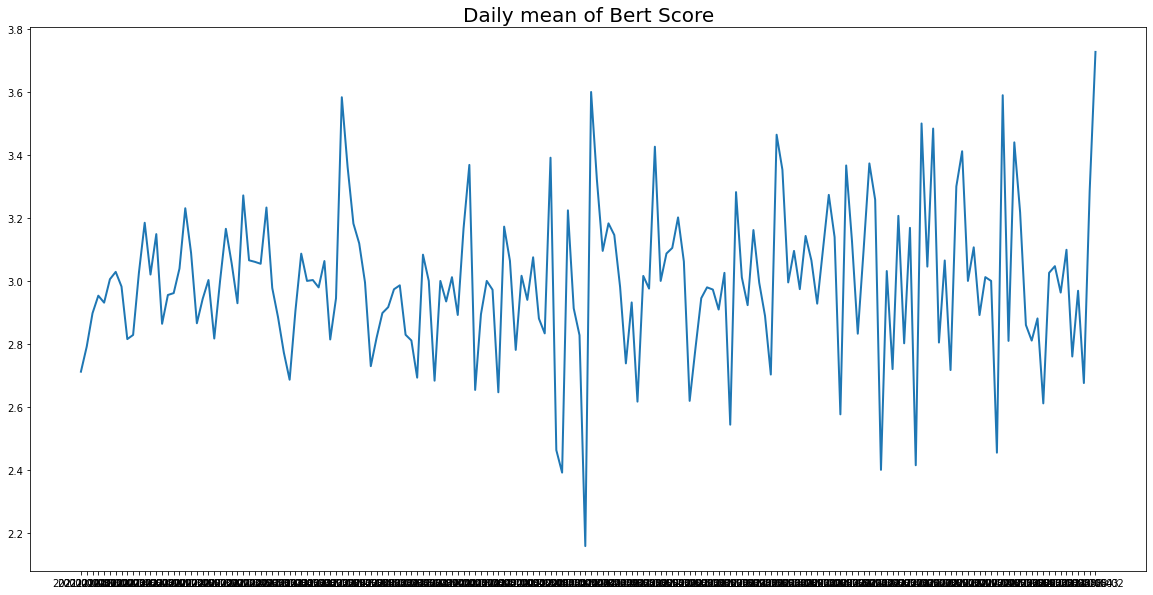

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
x = data_wsb2['day'].unique()
y_bert_score = data_wsb2.groupby(['day'])['sentiment_total'].mean()
plt.plot(x, y_bert_score, label = "bert",linewidth=2)
plt.title('Daily mean of Bert Score', fontsize = 20) # 1 is negative, 5 is positive

Text(0.5, 1.0, 'Daily Mean of Vader Socre')

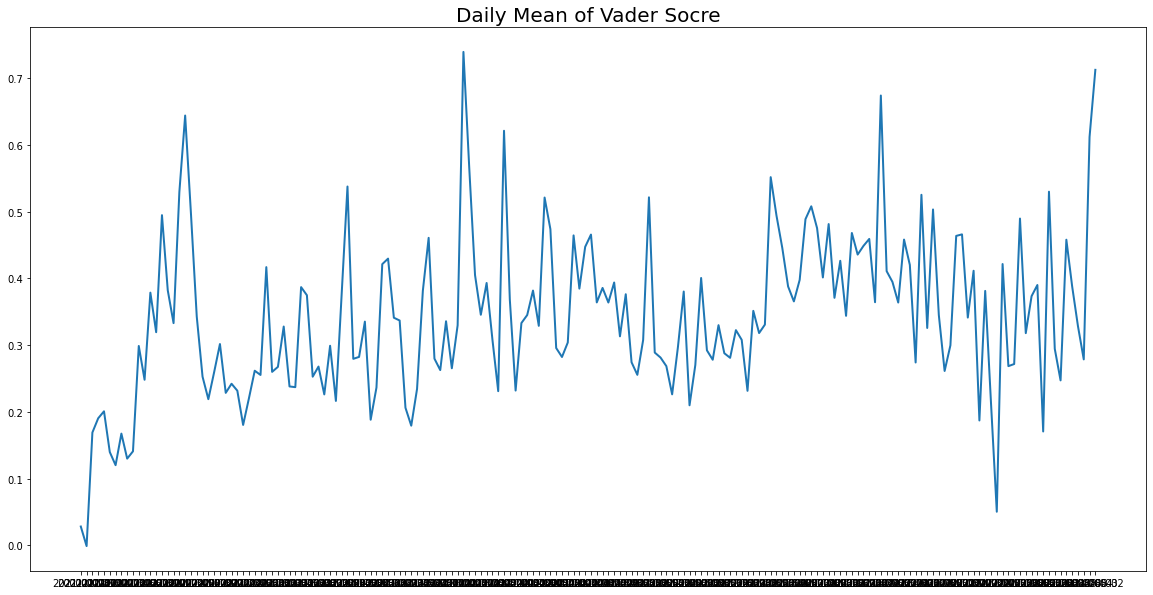

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
#x = data_wsb2['day'].unique()
y_vader_score = data_wsb2.groupby(['day'])['vader_score'].mean()
plt.plot(x, y_vader_score, label = "vader",linewidth=2)
plt.title('Daily Mean of Vader Socre', fontsize = 20)  # lower score means negative 

In [ ]:
toxic = data_wsb2[data_wsb2['toxic']==1]
severe_toxic = data_wsb2[data_wsb2['severe_toxic']==1]
obscene = data_wsb2[data_wsb2['obscene']==1]
threat = data_wsb2[data_wsb2['threat']==1]
insult = data_wsb2[data_wsb2['insult']==1]
identity_hate = data_wsb2[data_wsb2['identity_hate']==1]

In [ ]:
toxic['toxic'].sum()

7944

In [ ]:
x = data_wsb2['day'].unique()
y_toxic = data_wsb2.groupby(['day'])['toxic'].sum().values.tolist()
y_severe_toxic = data_wsb2.groupby(['day'])['severe_toxic'].sum().values.tolist()
y_obscene =  data_wsb2.groupby(['day'])['obscene'].sum().values.tolist()
y_insult = data_wsb2.groupby(['day'])['insult'].sum().values.tolist()
y_identity_hate = data_wsb2.groupby(['day'])['identity_hate'].sum().values.tolist()

In [ ]:
len(y_severe_toxic)

176

Text(0.5, 1.0, 'Toxicity Comments Detection')

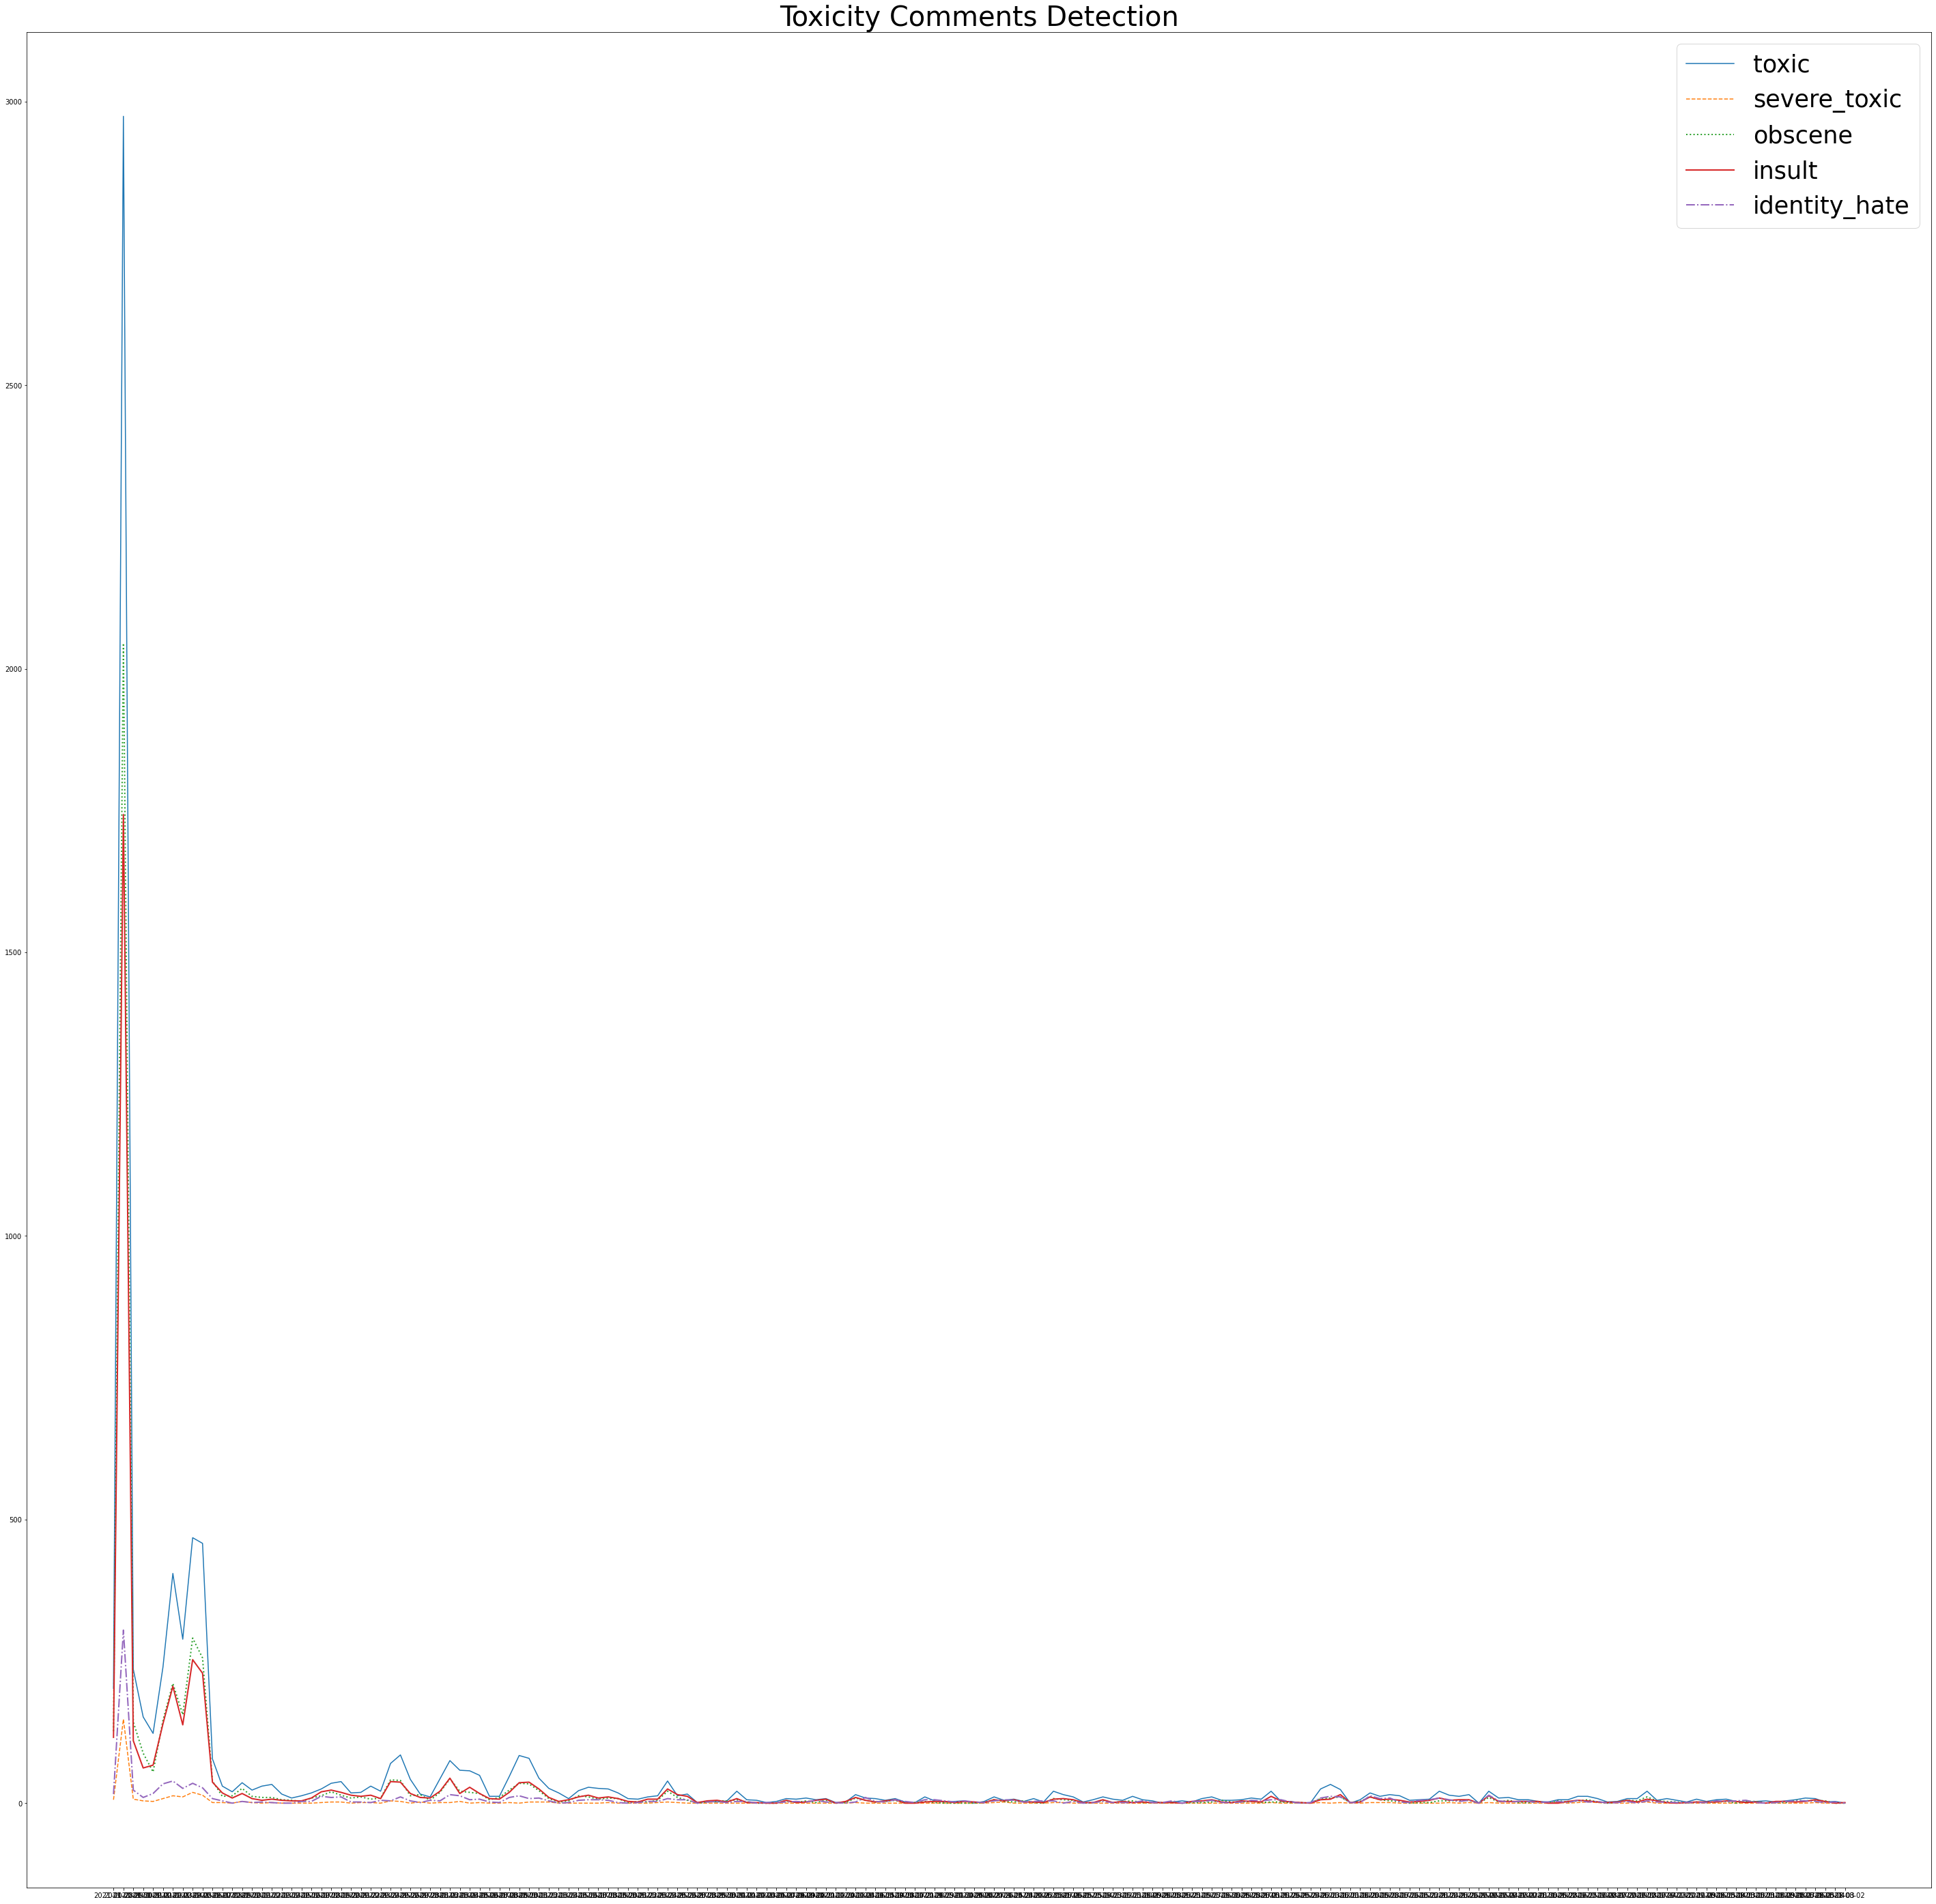

In [ ]:
plt.figure(figsize=(50,50))
plt.plot(x, y_toxic, label = "toxic", linestyle="-",  linewidth=1.5)
plt.plot(x, y_severe_toxic, label ='severe_toxic', linestyle="--", linewidth=1.5 )
plt.plot(x, y_obscene, label = "obscene", linestyle=":", linewidth=2)
plt.plot(x, y_insult, label = 'insult', linestyle = 'solid',  linewidth = 2)
plt.plot(x, y_identity_hate, label = 'identity_hate', linestyle = 'dashdot', linewidth = 2)
#plt.rcParams["figure.figsize"] = (70,50)
plt.legend(fontsize =35)
plt.title('Toxicity Comments Detection',fontsize=40) 